In [1]:
from src.scraping.get_data import *
from src.utils.checks import *
from src.portfolio.data_manipulation import *
from src.plots.basics import *
from src.computations.compute_returns import *
from src.computations.metrics import *

get_data_info()
data = get_data_updated_2025()

download_data_updated()

In [2]:
def merge_results(final_results, results):

    if final_results is None:
        return results
    else:
        merged_df = pd.merge(final_results, results, on="Date", how="outer")
        merged_df = merged_df.sort_values(by="Date").reset_index(drop=True)

        # Convert the 'Date' column to datetime (assuming MM/YYYY format)
        merged_df["Date"] = pd.to_datetime(merged_df["Date"], format="%m/%Y")

        # Sort by the datetime values
        merged_df = merged_df.sort_values(by="Date").reset_index(drop=True)

        # (Optional) Convert Date back to MM/YYYY string format if needed
        merged_df["Date"] = merged_df["Date"].dt.strftime("%m/%Y")

        return merged_df

In [60]:
get_list_of_portfolios()

['100_2factors',
 '80_20_ACWI',
 '80_20_World',
 '80_20_2factors',
 '80_20_1factor',
 '60_40_World']

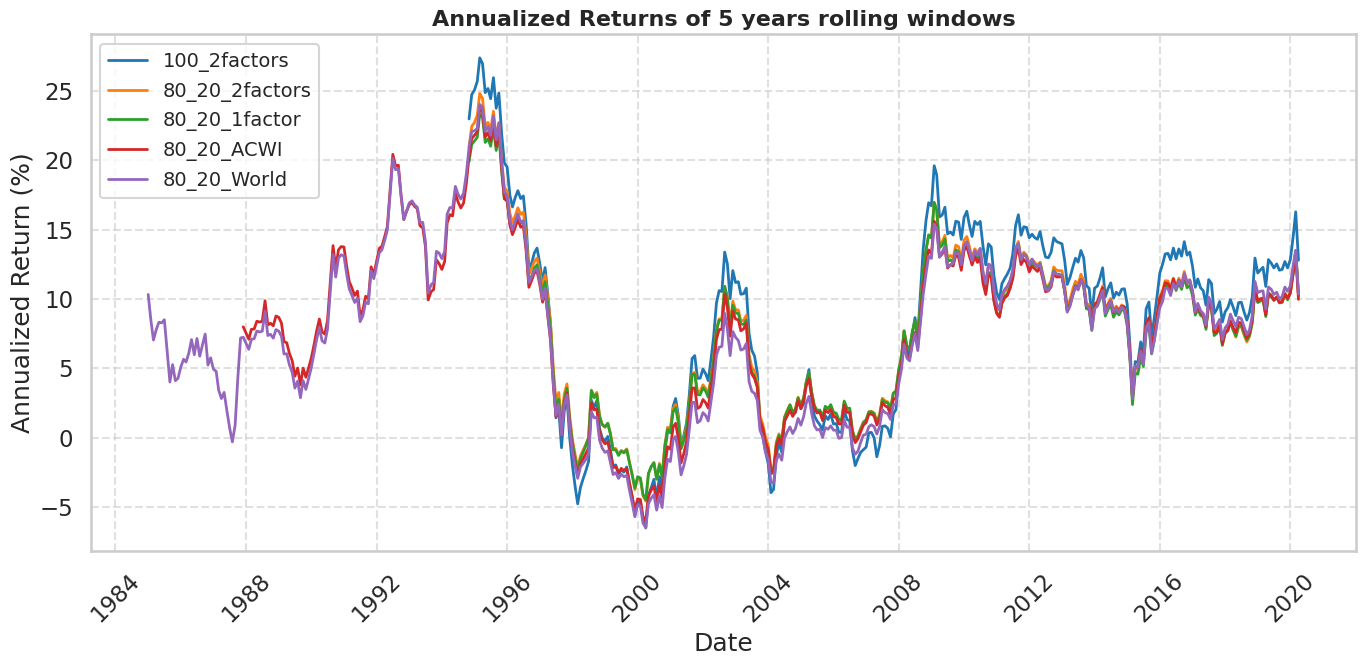

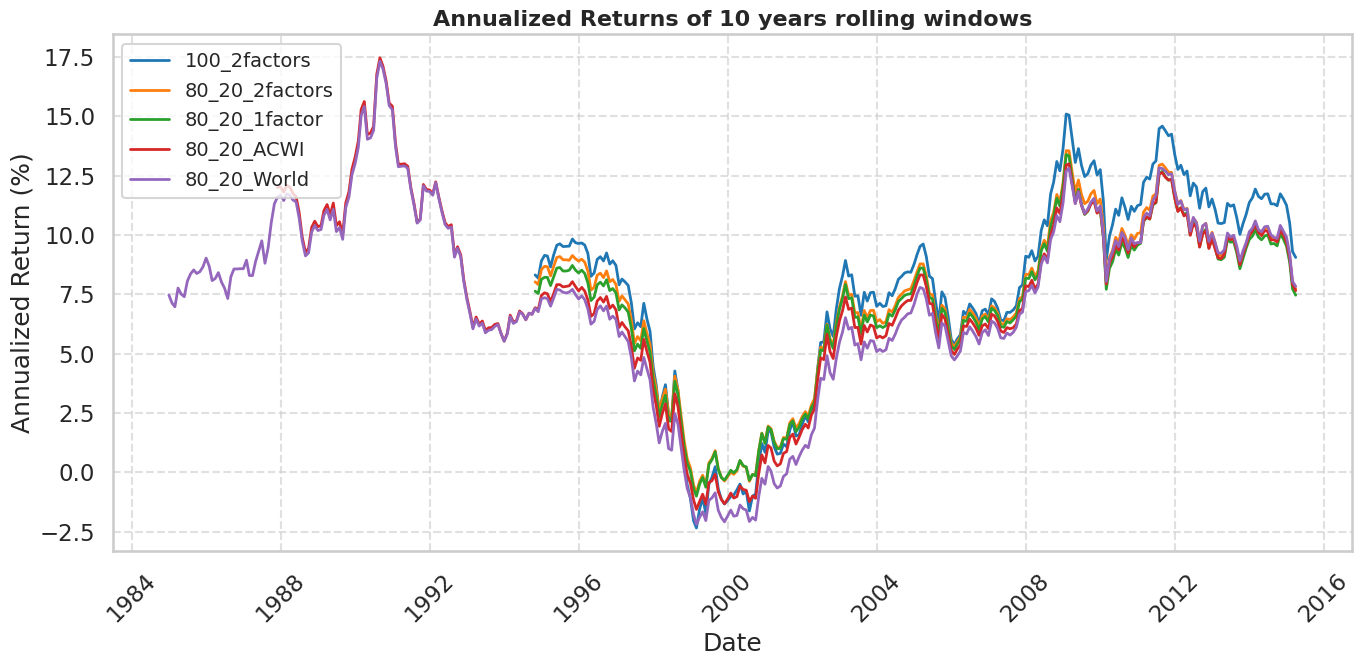

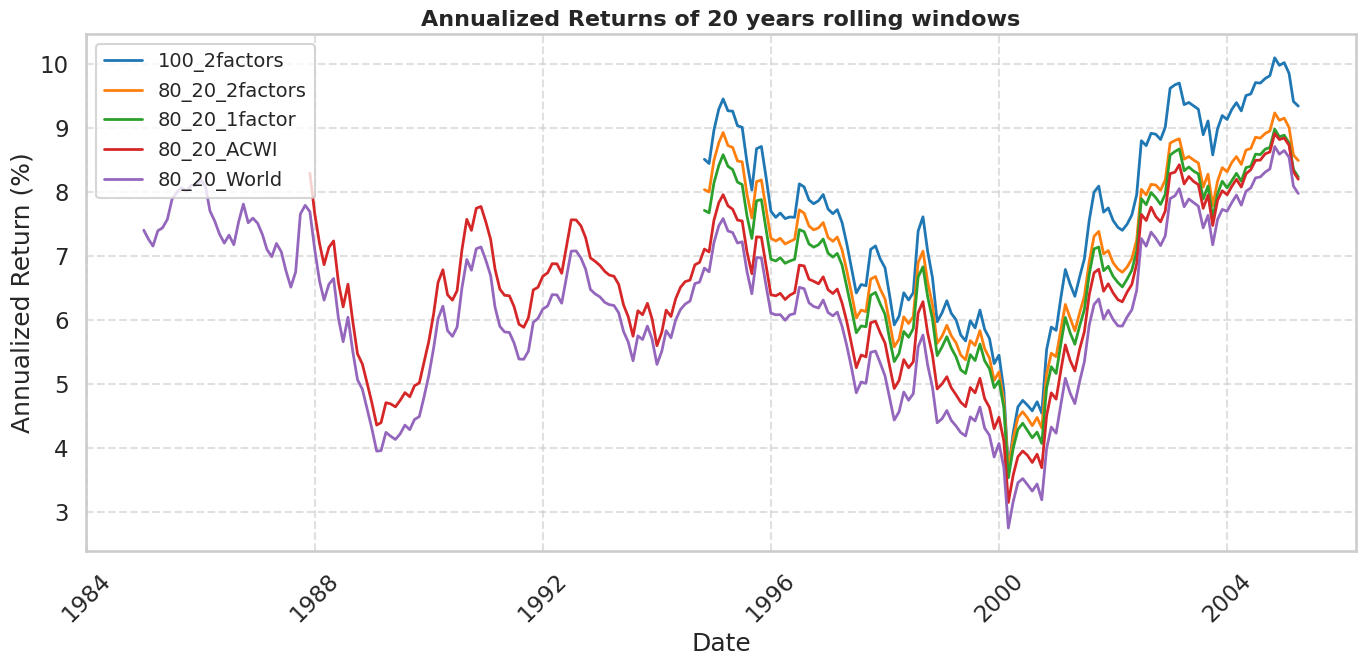

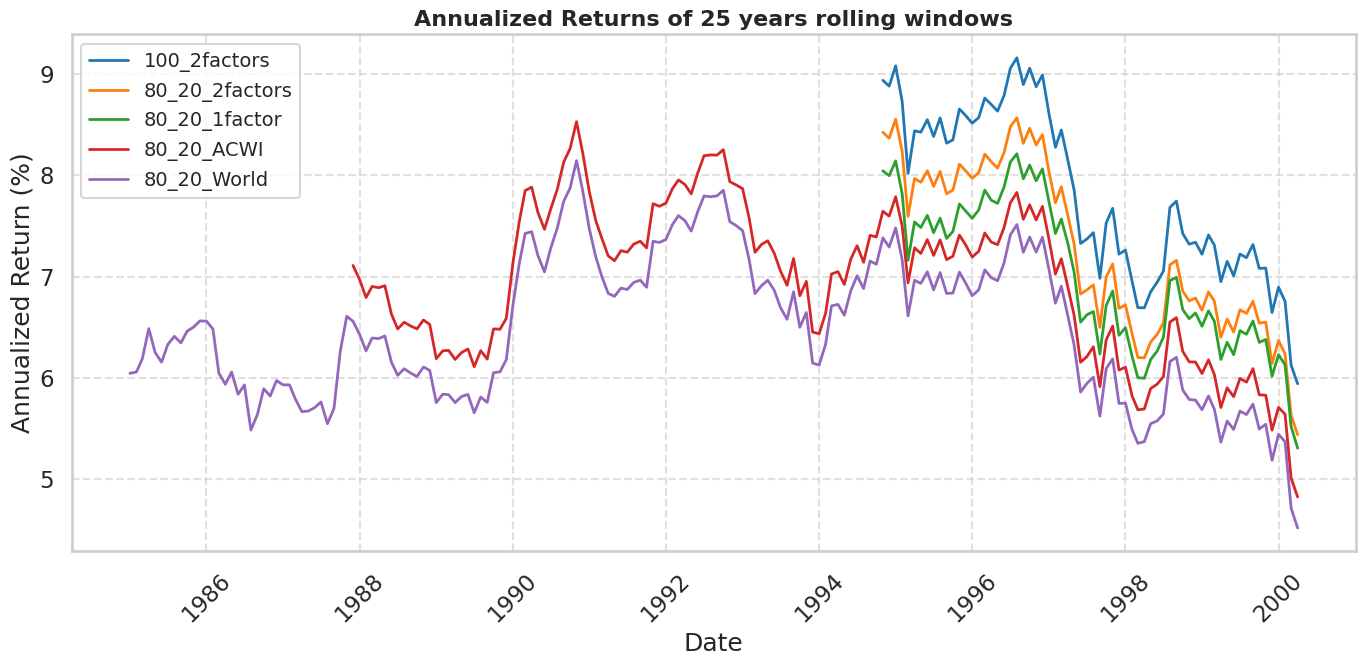

In [64]:
portfolios = ['100_2factors',
              '80_20_2factors',
              '80_20_1factor',
              '80_20_ACWI',
              '80_20_World']

for years in [5, 10, 20, 25]:
    final_results = None 
    for portfolio_name in portfolios:

        portfolio = load_portfolio(portfolio_name)
        data, weights = prune_data_portfolio(portfolio)

        # Compute the returns
        results = compute_portfolio_returns_combined(*prune_data_portfolio(portfolio), years=years)
        results = results.rename(columns={results.columns[-1]: portfolio_name})
        results[portfolio_name] = results[portfolio_name].round(5)

        final_results = merge_results(final_results, results)
    
    plot_annualized_returns(final_results, years=years)

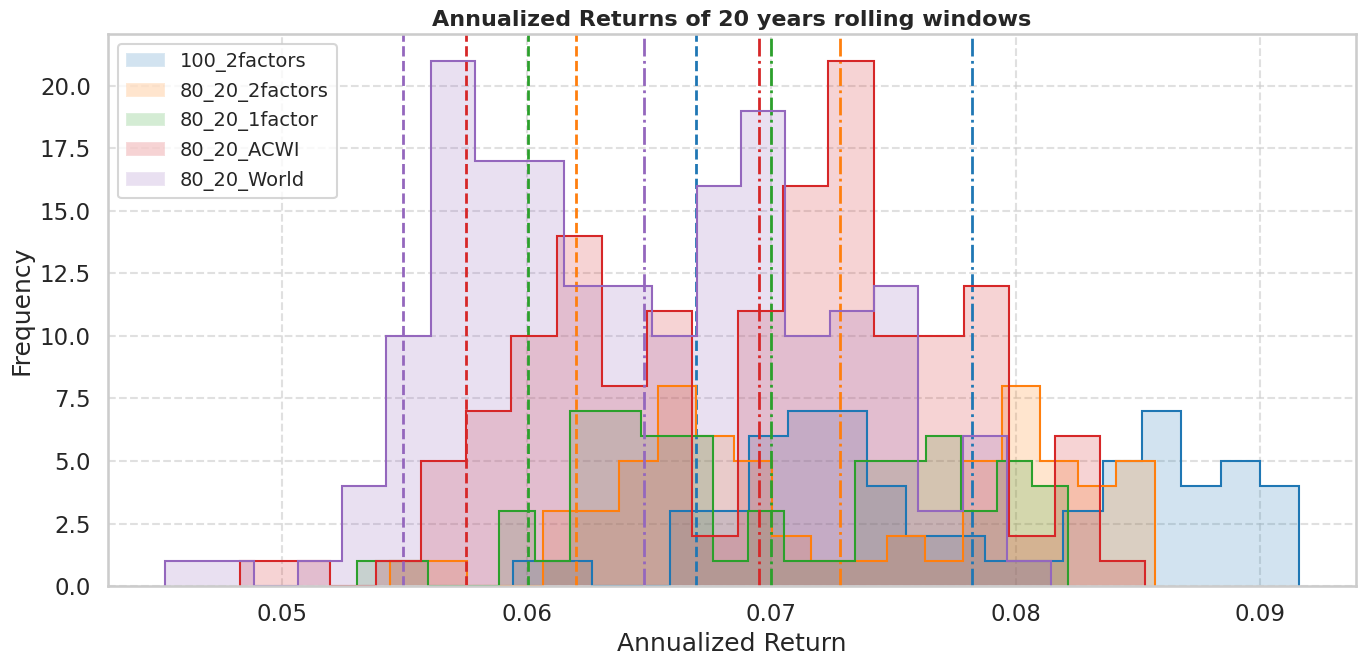

In [65]:
from scipy.stats import gmean

def compute_geometric_mean(returns_df):
    """
    Compute geometric mean of returns for each portfolio using scipy.stats.gmean
    """
    portfolio_columns = [col for col in returns_df.columns if col != 'Date']
    
    geo_means = {}
    for col in portfolio_columns:
        clean_returns = returns_df[col].dropna()
        decimal_returns = clean_returns
        geo_mean = gmean(1 + decimal_returns) - 1
        geo_means[col] = geo_mean 
        
    return pd.Series(geo_means).round(4)

def plot_returns_histogram(results, years=20, plot_figure=True):
    """
    Plot the maximum drawdown of the portfolios.
    """
    df = pd.DataFrame(results)
    
    # Compute and display geometric means
    geometric_means = compute_geometric_mean(df)
    portfolio_columns = [col for col in df.columns if col != 'Date']
    q5 = df[portfolio_columns].quantile(0.05)

    # Plot styling
    sns.set(style="whitegrid", context="talk")
    if plot_figure: plt.figure(figsize=(14, 7))
    palette = sns.color_palette("tab10", n_colors=len(df.columns[1:]))

    for i, col in enumerate(df.columns[1:]):
        plt.hist(df[col], histtype='stepfilled', bins=20, alpha=0.2, color=palette[i], label=col)
        plt.hist(df[col], histtype='step', bins=20, alpha=1, color=palette[i])
        plt.axvline(geometric_means[col], color=palette[i], linestyle='-.', linewidth=2)
        plt.axvline(q5[col], color=palette[i], linestyle='--', linewidth=2)

    plt.xlabel("Annualized Return")
    plt.ylabel("Frequency")
    plt.title(f"Annualized Returns of {years} years rolling windows", fontsize=16, fontweight='bold')

    # Improve date formatting
    ax = plt.gca()

    plt.legend(loc="upper left", fontsize=14)
    plt.grid(True, linestyle='--', alpha=0.6)

    plt.tight_layout()

plot_returns_histogram(final_results, plot_figure=True)

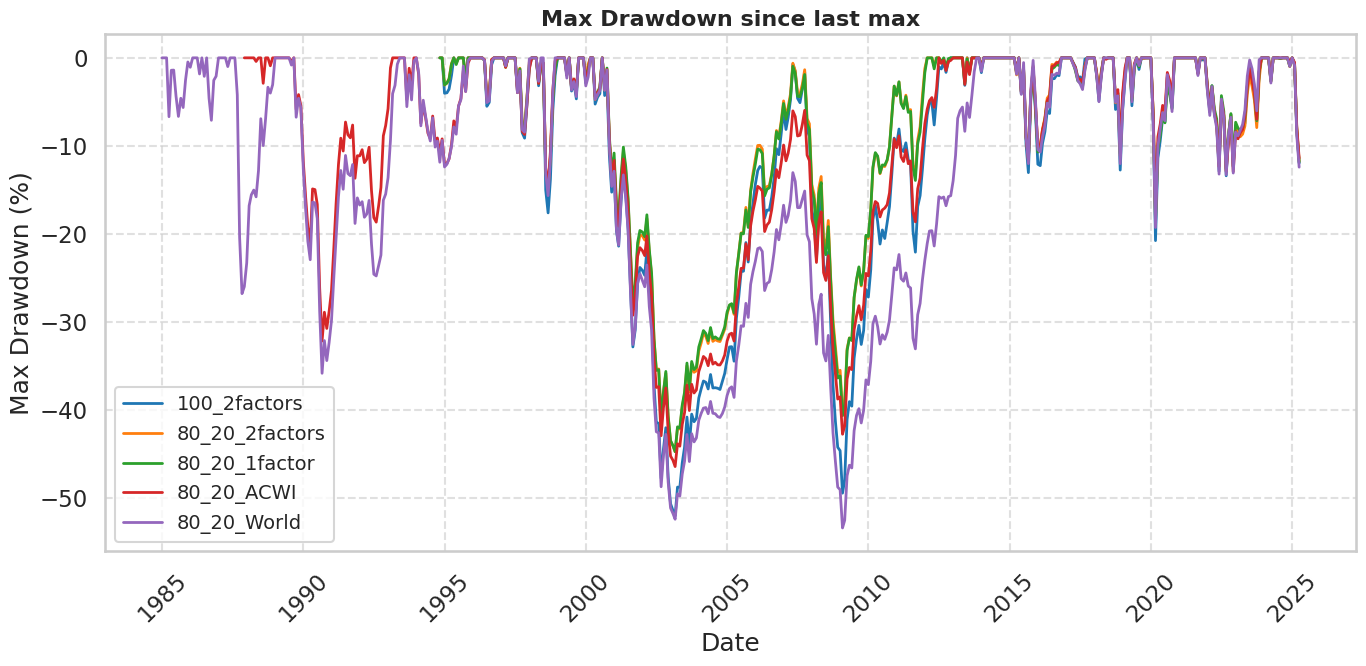

In [63]:
final_maxdrawdown = None

for portfolio_name in portfolios:

    portfolio = load_portfolio(portfolio_name)
    data, weights = prune_data_portfolio(portfolio)

    prices = compute_portfolio_prices(portfolio, portfolio_name)

    maxdrawdown = max_drawdown(prices)

    final_maxdrawdown = merge_results(final_maxdrawdown, maxdrawdown)

plot_max_drawdown(final_maxdrawdown)